In [1]:
!pip install pandas matplotlib nltk textblob wordcloud vaderSentiment seaborn graphviz
!python -m spacy download en_core_web_sm  

/Users/elizabethkudriavtsev/miniconda3/bin/python: No module named spacy


In [3]:
import pandas as pd

patientinfo = pd.read_csv("patient_posts.csv")
patientinfo = patientinfo.dropna(subset=['Content'])  # Drop rows where selftext is NaN


print(patientinfo.head())

print(patientinfo.isnull().sum())

print(patientinfo.describe())

           Author                Datetime  \
0  Emis_Moderator  2014-12-01T12:07+00:00   
1       jayneejay  2014-08-04T10:21+00:00   
2     vivian72668  2023-05-01T20:12+00:00   
3     vivian72668  2024-03-02T16:20+00:00   
4     vivian72668  2024-02-28T19:14+00:00   

                                               Title  \
0                                Menopause resources   
1  66 Peri menopause / Menopause Symptoms you may...   
2  Voodoo Doll Syndrome: Is someone pricking me w...   
3  PRE-MENOPAUSE: Ladies, who were you before MEN...   
4      POST-MENOPAUSAL Nervous Bladder: Anyone Else?   

                                             Content  
0  Below are various resources for Menopause from...  
1  SIXTY-SIX PHYSICAL SYMPTOMS: Part one 1 - 49 T...  
2  Hey Ladies... Have you ever felt as if someone...  
3  Hello There, Lovely Ladies Who were you, befor...  
4  Hey Ladies... For the past week and a half, my...  
Author      0
Datetime    0
Title       0
Content     0
dtype:

In [5]:
import pandas as pd

# Define lists of keywords
symptoms = {
    'VMS': {
        'Hot Flashes': ['hot flush', 'hot flash'],
        'Sweating': ['perspiration', 'sweating', 'night sweats'],
        'Blood Pressure': ['high BP','high blood pressure','hypertension'],
        'Tachycardia': ['tachycardia', 'heart racing', 'palpitations', 'high heart rate']
    },
    'GSM': {
        'Genital Issues': [ 'vaginal dryness', 'itch', 'itching', 'burn', 'burning', 'irritation'],
        'Urinary Issues': ['urination', 'peeing', 'urinary urgency', 'incontinence', 'incontinent', 'uti'],
        'Menstrual Issues': ['irregular periods', 'bleeding', 'spotting']
    },
    'Mental Health': {
        'Anxiety': ['anxiety', 'anxious'],
        'Depression': ['depressed', 'depression'],
        'Mood Issues': ['mood swings', 'moody', 'irritable', 'irritated'],
        'Mental Issues': ['difficulty concentrating','brain fog']
       
    },
    'Other': {
        'Headaches': ['headache', 'migraine'],
        'Acne': ['acne'],
        'breast soreness': ['breast soreness', 'breast pain'],
        'hair thinning': ['hair thinning', 'hair fall', 'losing hair'],
        'Osteoporosis': ['osteoporosis','osteoarthritis'],
        'Gastrointestinal': ['bloating','IBS'],
        'Sexual Issues': ['decreased libido', 'low sex drive', 'pain during sex'],
        'Fatigue': ['fatigue', 'tired', 'insomnia', 'cant sleep', 'poor sleep', 'bad sleep', 'waking up at night']
    }
}

treatments = {
    'Hormone Therapy': {
        'Classic MHT': ['mht', 'iud', 'hrt', 'estrogen', 'progesterone', 'hormone therapy', 'combined oral contraceptive', 'EPT', 'ET', 'Estrogen Progesterone Therapy'],
        'Novel hormone treatments': ['Tibolone', 'livial', 'TSEC', 'Tissue-Selective Estrogen Complex', 'Duavee', 'Ospemifene', 'Lasofoxifene', 'testosterone']
    },
    'Non-Hormonal Treatments': {
        'Fezolinetan': ['Fezolinetan', 'nk3', 'vezoah', 'neurokinin 3', 'nk3 receptor antagonist'],
        'Herbal': ['red clover', 'black cohosh', 'soybean', 'omega-3', 'phytoestrogen', 's-eqol', 'isoflavone', 'LNG-IUS', 'compounded bioidentical hormones', 'natural hormone', 'natural estrogen', 'bazedoxifene']
    },
    'Lifestyle': {
        'Lifestyle Modifications': ['exercise', 'diet', 'CBT', 'cognitive behavioral therapy', 'yoga', 'weight loss', 'meditation']
    },
    'Other Prescription Drugs': {
        'Fezolinetan': ['Fezolinetan', 'nk3', 'vezoah', 'neurokinin 3', 'nk3 receptor antagonist'],
        'Clonidine': ['clonidine'],
        'Gabapentin': ['gabapentin'],
        'Antidepressants': ['antidepressant', 'Brisdelle', 'SNRI','SSRI', 'Lexapro', 'Celexa', 'Effexor']
    }
}

# Function to detect keywords in posts
def extract_keywords(text, keyword_list):
    return [kw for kw in keyword_list if kw.lower() in text.lower()]

# Apply keyword extraction to the 'selftext' column
patientinfo['symptoms'] = patientinfo['Content'].apply(lambda x: extract_keywords(str(x), symptoms))

# Function to extract specific treatments
def extract_specific_treatments(text, treatments_list):
    return [treatment for treatment in treatments_list if treatment.lower() in text.lower()]

# Apply the extraction function for treatments to the 'selftext' column
patientinfo['treatments'] = patientinfo['Content'].apply(lambda x: extract_specific_treatments(str(x), treatments))

# Check the results
print(patientinfo[['Content', 'symptoms', 'treatments']].head())
print(f"DataFrame shape: {patientinfo.shape}")          # Check number of rows and columns
print(f"Columns: {patientinfo.columns}")                # Check the names of all columns
print(f"Types in selftext: {patientinfo['Content'].apply(type).value_counts()}")  # Check types in selftext



                                             Content symptoms treatments
0  Below are various resources for Menopause from...       []         []
1  SIXTY-SIX PHYSICAL SYMPTOMS: Part one 1 - 49 T...  [Other]         []
2  Hey Ladies... Have you ever felt as if someone...       []         []
3  Hello There, Lovely Ladies Who were you, befor...       []         []
4  Hey Ladies... For the past week and a half, my...       []         []
DataFrame shape: (11646, 6)
Columns: Index(['Author', 'Datetime', 'Title', 'Content', 'symptoms', 'treatments'], dtype='object')
Types in selftext: Content
<class 'str'>    11646
Name: count, dtype: int64


Step 4: Extract Symptoms and Treatments using Keyword Matching; Define keywords related to symptoms and treatments to tag posts automatically.

most referenced subcategory symptoms from each category (VMS, GSM, Mental Health, and Other) 

In [6]:
# Initialize a dictionary to hold symptom and treatment counts
symptom_treatment_data = {symptom: [] for category in symptoms for symptom in symptoms[category]}

# Extract symptoms and treatments from the Reddit text
for index, row in patientinfo.iterrows():
    text = row['Content'].lower()  # Convert to lower case for easier matching

    # Check for symptoms
    for category, subcategories in symptoms.items():
        for symptom, synonyms in subcategories.items():
            # Check if any synonym is in the text
            if any(synonym in text for synonym in synonyms):
                # Initialize treatment counts for this symptom occurrence
                treatment_counts = {treatment_category: {sub_treatment: 0 for sub_treatment in treatments[treatment_category]} for treatment_category in treatments}

                # Count treatments mentioned alongside symptoms
                for treatment_category, sub_treatments in treatments.items():
                    for sub_treatment, treatment_synonyms in sub_treatments.items():
                        for treatment in treatment_synonyms:
                            if treatment in text:
                                treatment_counts[treatment_category][sub_treatment] += 1

                # Store the counts for this symptom occurrence
                symptom_treatment_data[symptom].append(treatment_counts)

# Now, calculate the total counts for each symptom and treatments
symptom_counts = []
for symptom, treatment_list in symptom_treatment_data.items():
    # Aggregate counts for treatments across all occurrences of this symptom
    total_counts = {treatment_category: {sub_treatment: sum(d.get(treatment_category, {}).get(sub_treatment, 0) for d in treatment_list) for sub_treatment in treatments[treatment_category]} for treatment_category in treatments}
    symptom_counts.append((symptom, total_counts))

# Create a DataFrame from the counts
count_df = pd.DataFrame(symptom_counts, columns=['symptom', 'treatment'])

# Display the DataFrame
print(count_df)


             symptom                                          treatment
0        Hot Flashes  {'Hormone Therapy': {'Classic MHT': 408, 'Nove...
1           Sweating  {'Hormone Therapy': {'Classic MHT': 200, 'Nove...
2     Blood Pressure  {'Hormone Therapy': {'Classic MHT': 19, 'Novel...
3        Tachycardia  {'Hormone Therapy': {'Classic MHT': 133, 'Nove...
4     Genital Issues  {'Hormone Therapy': {'Classic MHT': 290, 'Nove...
5     Urinary Issues  {'Hormone Therapy': {'Classic MHT': 153, 'Nove...
6   Menstrual Issues  {'Hormone Therapy': {'Classic MHT': 295, 'Nove...
7            Anxiety  {'Hormone Therapy': {'Classic MHT': 686, 'Nove...
8         Depression  {'Hormone Therapy': {'Classic MHT': 320, 'Nove...
9        Mood Issues  {'Hormone Therapy': {'Classic MHT': 157, 'Nove...
10     Mental Issues  {'Hormone Therapy': {'Classic MHT': 65, 'Novel...
11         Headaches  {'Hormone Therapy': {'Classic MHT': 266, 'Nove...
12              Acne  {'Hormone Therapy': {'Classic MHT': 26, 'N

Count amount of references each symptom has:

In [7]:
symptom_reference_counts = {category: {subcategory: 0 for subcategory in subcategories} for category, subcategories in symptoms.items()}

# Extract symptoms from the Reddit text
for index, row in patientinfo.iterrows():
    text = row['Content'].lower()  # Convert to lower case for easier matching

    # Check for symptoms
    for category, subcategories in symptoms.items():
        for subcategory, synonyms in subcategories.items():
            # Check if any synonym is in the text
            if any(synonym in text for synonym in synonyms):
                symptom_reference_counts[category][subcategory] += 1

# Prepare a DataFrame for results
results = []

# Compile results for ranking
for category, subcategories in symptom_reference_counts.items():
    for subcategory, count in subcategories.items():
        results.append((category, subcategory, count))

# Create a DataFrame
results_df = pd.DataFrame(results, columns=['Category', 'Sub-Symptom', 'Count'])

# Group by category and sort by count
ranked_symptoms = results_df.sort_values(['Category', 'Count'], ascending=[True, False])

# Display the ranked symptoms
for category in ranked_symptoms['Category'].unique():
    print(f"--- {category} ---")
    print(ranked_symptoms[ranked_symptoms['Category'] == category][['Sub-Symptom', 'Count']])
    print()



category_totals = results_df.groupby('Category')['Count'].sum()
total_references = category_totals.sum()

#Calculate and display percentages for each category
percentages = (category_totals / total_references) * 100
print("--- Category Percentage of Total ---")
for category, percentage in percentages.items():
    print(f"{category}: {percentage:.2f}%")

--- GSM ---
        Sub-Symptom  Count
4    Genital Issues   1166
6  Menstrual Issues   1032
5    Urinary Issues    466

--- Mental Health ---
      Sub-Symptom  Count
7         Anxiety   2872
8      Depression    806
9     Mood Issues    420
10  Mental Issues    192

--- Other ---
         Sub-Symptom  Count
18           Fatigue   1487
11         Headaches   1048
16  Gastrointestinal    259
13   breast soreness     99
12              Acne     54
14     hair thinning     36
15      Osteoporosis     32
17     Sexual Issues     10

--- VMS ---
      Sub-Symptom  Count
0     Hot Flashes   1118
1        Sweating    554
3     Tachycardia    464
2  Blood Pressure     55

--- Category Percentage of Total ---
GSM: 21.89%
Mental Health: 35.25%
Other: 24.86%
VMS: 18.00%


In [9]:
# Now extract the top 5 treatments for each symptom
top_treatments = []
for index, row in count_df.iterrows():
    symptom = row['symptom']
    treatment_counts = row['treatment']
    
    # Flatten treatment counts into a single list of tuples
    flattened_counts = []
    for treatment_category, sub_treatments in treatment_counts.items():
        for sub_treatment, count in sub_treatments.items():
            if count > 0:  # Only include treatments that were counted
                flattened_counts.append((sub_treatment, count))
    
    # Get top 5 treatments based on counts
    top_5 = sorted(flattened_counts, key=lambda x: x[1], reverse=True)[:5]
    top_treatments.append((symptom, top_5))

# Create a new DataFrame to display the top treatments
patient_top_treatments_df = pd.DataFrame(top_treatments, columns=['symptom', 'top_treatments'])

# Display the DataFrame
patient_top_treatments_df

patient_top_treatments_df.to_csv('patientinfotoptreatments.csv', index=False)


Visualization options 10/24: #2 Preferred

In [43]:
#1

import pandas as pd
from graphviz import Digraph

# Initialize Digraph with a hierarchical layout
flowchart = Digraph(
    format='png',
    engine='dot',  # 'dot' for a top-down hierarchical structure
    graph_attr={
        'rankdir': 'TB',  # Top to Bottom
        'fontsize': '20',
        'label': 'Reddit: Symptoms and Treatments',
        'labelloc': 't',
        'ranksep': '1.5',  # Space between ranks (categories -> symptoms -> treatments)
        'nodesep': '1.0',  # Space between nodes at the same rank
    }
)

# Category colors
category_colors = {
    "Mental Health": "#a9d6eb",
    "Genitourinary (GSM)": "#b7e0d8",
    "Vasomotor (VMS)": "#b9d5f1",
    "Other": "#d0e2f2"
}

# Define categories and symptoms
categories = {
    "Mental Health": ['anxiety', 'depression', 'irritability'],
    "Genitourinary (GSM)": ['vaginal dryness', 'itch', 'uti', 'irregular periods'],
    "Vasomotor (VMS)": ['hot flash', 'palpitations', 'fatigue', 'insomnia'],
    "Other": ['hair thinning', 'breast soreness', 'weight gain', 'bloating', 'osteoporosis']
}

# Calculate total references
total_references = treatments_df.sum().sum()

# Create category clusters and nodes
for category, symptoms in categories.items():
    with flowchart.subgraph(name=f'cluster_{category}') as subgraph:
        subgraph.attr(label=category, style='filled', color=category_colors[category])

        # Create the category node
        subgraph.node(category, shape='circle', fillcolor=category_colors[category], fontsize='14', style='filled')

        # Sum all treatment counts for this category
        category_df = count_df[count_df['symptom'].isin(symptoms)]
        category_count = category_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum().sum()

        # Add symptom nodes and edges
        for symptom in symptoms:
            symptom_df = category_df[category_df['symptom'] == symptom]
            total_treatment_count = symptom_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum().sum()

            # Symptom node with connections to the category
            symptom_label = f"{symptom} ({total_treatment_count} references)"
            subgraph.node(symptom_label, shape='oval', fillcolor='lightblue', fontsize='12', width='2.5', height='1.5')
            subgraph.edge(category, symptom_label)

            # Add treatment nodes and edges - Limit to top 5 treatments based on frequency
            treatment_counts = symptom_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum()
            top_5_treatments = treatment_counts.nlargest(5).index  # Get the top 5 treatments

            for treatment in top_5_treatments:
                count = treatment_counts[treatment]

                if count > 0:
                    treatment_label = f"{treatment} ({count} references)"

                    flowchart.node(treatment_label, shape='box', fillcolor='lightyellow', fontsize='10', width='2.0', height='1.0')
                    flowchart.edge(symptom_label, treatment_label)

# Render the flowchart
flowchart.render('menochart_clean_hierarchical', format='png', cleanup=True)

print("Flowchart saved as 'menochart_clean_hierarchical.png'")
 

Flowchart saved as 'menochart_clean_hierarchical.png'


In [9]:
#2

import pandas as pd
from graphviz import Digraph

# Verify structure
print("Columns in count_df:", count_df.columns)
print("Columns in treatments_df:", treatments_df.columns)

# Initialize Digraph with better layout and increased spacing
flowchart = Digraph(
    format='png',
    engine='fdp',  # 'fdp' for better force-directed layouts
    graph_attr={
        'rankdir': 'TB',
        'fontsize': '20',
        'label': 'Reddit: Symptoms and Treatments',
        'labelloc': 't',
        'ranksep': '3.0',  # Further increase vertical spacing
        'nodesep': '3.0',  # Further increase horizontal spacing for clarity
    }
)

# Category colors
category_colors = {
    "Mental Health": "#a9d6eb",
    "Genitourinary (GSM)": "#b7e0d8",
    "Vasomotor (VMS)": "#b9d5f1",
    "Other": "#d0e2f2"
}

# Define categories and symptoms
categories = {
    "Mental Health": ['anxiety', 'depression', 'irritability'],
    "Genitourinary (GSM)": ['vaginal dryness', 'itch', 'uti', 'irregular periods'],
    "Vasomotor (VMS)": ['hot flash', 'palpitations', 'fatigue', 'insomnia'],
    "Other": ['hair thinning', 'breast soreness', 'weight gain', 'bloating', 'osteoporosis']
}

# Calculate total references
total_references = treatments_df.sum().sum()

# Create category clusters and nodes
for category, symptoms in categories.items():
    with flowchart.subgraph(name=f'cluster_{category}') as subgraph:
        subgraph.attr(label=category, style='filled', color=category_colors[category])

        # Sum all treatment counts for this category
        category_df = count_df[count_df['symptom'].isin(symptoms)]
        category_count = category_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum().sum()
        percent = (category_count / total_references * 100) if total_references > 0 else 0

        # Create the category node
        category_label = f"{category} ({percent:.1f}%)"
        subgraph.node(category_label, shape='circle', fillcolor=category_colors[category], fontsize='14', style='filled')

        # Add symptom nodes and edges
        for symptom in symptoms:
            symptom_df = category_df[category_df['symptom'] == symptom]
            total_treatment_count = symptom_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum().sum()

            symptom_label = f"{symptom} ({total_treatment_count} references)"
            subgraph.node(symptom_label, shape='oval', fillcolor='lightblue', fontsize='12', width='2.5', height='1.5')
            subgraph.edge(category_label, symptom_label)

            # Add treatment nodes and edges - Limit to top 5 treatments based on frequency
            treatment_counts = symptom_df.drop(columns=['symptom', 'treatment'], errors='ignore').sum()
            top_5_treatments = treatment_counts.nlargest(5).index  # Get the top 5 treatments

            for treatment in top_5_treatments:
                count = treatment_counts[treatment]

                if count > 0:
                    treatment_percent = (count / total_treatment_count * 100) if total_treatment_count > 0 else 0
                    treatment_label = f"{treatment} ({count}, {treatment_percent:.1f}%)"

                    flowchart.node(treatment_label, shape='box', fillcolor='lightyellow', fontsize='10', width='2.0', height='1.0')
                    flowchart.edge(symptom_label, treatment_label)

# Render the flowchart
flowchart.render('menochart_spaced', format='png', cleanup=True)

print("Flowchart saved as 'menochart_spaced.png'")


Columns in count_df: Index(['symptom', 'treatment', 'MHT', 'HRT', 'Tiblone', 'Fezolinetan', 'Nk3',
       'TSEC', 'Tissue-Selective Estrogen Complex', 'EPT', 'ET',
       'Estrogen Progesterone Therapy', 'Estrogen Therapy', 'progesterone',
       'hormone therapy', 'combined oral contraceptive', 'COC',
       'levonorgestrel releasing-intrauterine system', 'tablets', 'capsules',
       'skin patch', 'gels', 'vaginal cream', 'intrauterine device', 'IUD',
       'CBT', 'weight loss', 'exercise', 'yoga', 'diet', 'herbal', 'clonidine',
       'gabapentin', 'SSRI', 'antidepressants', 'red clover', 'black cohosh',
       'soybean, omega-3', 'phytoestrogen', 's-eqol', 'isoflavone', 'LNG-IUS',
       'compounded bioidentical hormones', 'natural hormone',
       'natural estrogen', 'bazedoxifene', 'SERM'],
      dtype='object')
Columns in treatments_df: Index(['MHT', 'HRT', 'Tiblone', 'Fezolinetan', 'Nk3', 'TSEC',
       'Tissue-Selective Estrogen Complex', 'EPT', 'ET',
       'Estrogen Progest

Additional Visualizations

In [29]:
#additional combined dataframe of symptoms and treatments

import pandas as pd

# Assuming 'count_df' is already loaded as shown in your description

# Drop rows where all treatment values are zero
# First, create a mask for columns to keep
mask = (count_df.drop(columns=['symptom', 'treatment'], errors='ignore') != 0).any(axis=0)

# Use the mask to select columns (re-index to make sure alignment matches)
columns_to_keep = ['symptom', 'treatment'] + mask[mask].index.tolist()

# Keep only relevant columns
count_df = count_df.loc[:, count_df.columns.isin(columns_to_keep)]

# Group by symptoms and aggregate treatment counts (sum of counts for each treatment by symptom)
aggregated_df = count_df.groupby('symptom').sum().reset_index()

# Display the final DataFrame
aggregated_df
#aggregated_df.to_csv('symptomstreatmentsreddittable.csv', index=False) 


,symptom,treatment
0,GSM,"{'MHT': 0, 'HRT': 0, 'Tiblone': 0, 'Fezolineta..."
1,Mental Health,"{'MHT': 0, 'HRT': 0, 'Tiblone': 0, 'Fezolineta..."
2,Other,"{'MHT': 0, 'HRT': 0, 'Tiblone': 0, 'Fezolineta..."
3,VMS,"{'MHT': 0, 'HRT': 0, 'Tiblone': 0, 'Fezolineta..."


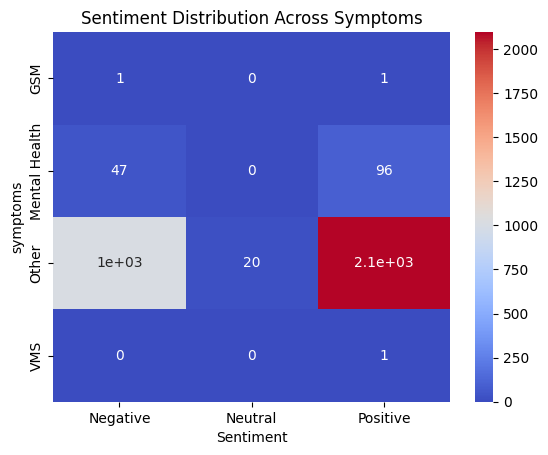

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table of symptoms vs. sentiment
pivot = Reddit.explode('symptoms').pivot_table(index='symptoms', columns='Sentiment', aggfunc='size', fill_value=0)

# Plot a heat map
sns.heatmap(pivot, cmap='coolwarm', annot=True)
plt.title('Sentiment Distribution Across Symptoms')
plt.show()
